In [13]:
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import sf_quant.data as sfd
import sf_quant.optimizer as sfo
import sf_quant.performance as sfp
from tqdm import tqdm
import datetime as dt

In [14]:
alpha_data = pl.read_parquet("../signal_weights/signal_data.parquet").with_columns(pl.col('return').shift(-1).over('barrid').alias('fwd_return'))

alpha_data

date,barrid,ticker,price,return,specific_return,specific_risk,historical_beta,predicted_beta,market_cap,daily_volume,bid_ask_spread,log_return,momentum,meanrev,bab,momentum_z,meanrev_z,bab_z,momentum_alpha,meanrev_alpha,bab_alpha,fwd_return
date,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2013-07-31,"""USA06Z1""","""MDXG""",6.26,-0.001595,-0.00788,0.550569,0.328385,0.34349,6.006157e8,121693.0,0.01,-0.001596,null,null,-0.34349,null,null,2.149267,null,null,0.059166,0.009585
2013-08-01,"""USA06Z1""","""MDXG""",6.32,0.009585,0.00365,0.55028,0.334989,0.353329,6.0865392e8,131728.0,0.01,0.009539,null,null,-0.353329,null,null,2.111728,null,null,0.058102,-0.001582
2013-08-02,"""USA06Z1""","""MDXG""",6.31,-0.001582,-0.00731,0.548074,0.330713,0.363624,6.0769086e8,43252.0,0.01,-0.001583,null,null,-0.363624,null,null,2.086144,null,null,0.057168,0.022187
2013-08-05,"""USA06Z1""","""MDXG""",6.45,0.022187,0.01936,0.547667,0.324494,0.356596,6.211737e8,70944.0,0.02,0.021944,null,null,-0.356596,null,null,2.098288,null,null,0.057458,-0.024806
2013-08-06,"""USA06Z1""","""MDXG""",6.29,-0.024806,-0.00528,0.546922,0.366323,0.399196,6.0576474e8,77085.0,0.01,-0.025119,null,null,-0.399196,null,null,2.001238,null,null,0.054726,-0.081081
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-09-09,"""USBRKA2""","""GLIBA""",36.225,-0.004261,0.01121,0.208427,0.236481,0.302514,1.3226e8,31025.0,0.11,-0.00427,null,-0.007341,-0.302514,null,0.37369,2.013268,null,0.003894,0.020981,0.000414
2025-09-10,"""USBRKA2""","""GLIBA""",36.24,0.000414,0.02305,0.209547,0.252015,0.29845,1.3231e8,6298.0,0.21,0.000414,null,-0.020066,-0.29845,null,0.247624,2.007619,null,0.002594,0.021035,0.022351
2025-09-11,"""USBRKA2""","""GLIBA""",37.05,0.022351,0.00213,0.214807,0.256752,0.31384,1.3527e8,26857.0,0.25,0.022105,null,-0.065239,-0.31384,null,0.07841,1.987568,null,0.000842,0.021347,-0.023752


In [15]:
weights_data = pl.read_parquet("../signal_weights/weights/low_vol_weights_pivot.parquet")

weights_data

date,barrid,bab_weight,meanrev_weight,momentum_weight
date,str,f64,f64,f64
1995-06-30,"""USAA191""",-1.3385e-21,null,null
1995-06-30,"""USAA1W1""",-7.2210e-22,null,null
1995-06-30,"""USAA1Y1""",-1.5558e-21,null,null
1995-06-30,"""USAA2L1""",1.1880e-22,null,null
1995-06-30,"""USAA311""",0.000052,null,null
…,…,…,…,…
2025-09-15,"""USBQZR1""",-9.5270e-22,-1.6546e-22,null
2025-09-15,"""USBRGT1""",-2.7019e-22,5.6211e-23,null
2025-09-15,"""USBRH21""",-1.1628e-21,-2.2827e-22,null


In [16]:
big_data = alpha_data.join(weights_data, on=["date", "barrid"], how="inner").select(['date', 'barrid', 'return', 'fwd_return', 'predicted_beta', 'momentum_alpha', 'meanrev_alpha', 'bab_alpha', 'momentum_weight', 'meanrev_weight', 'bab_weight'])

big_data

date,barrid,return,fwd_return,predicted_beta,momentum_alpha,meanrev_alpha,bab_alpha,momentum_weight,meanrev_weight,bab_weight
date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
1995-06-30,"""USAA191""",0.051471,-0.013986,0.823795,null,null,0.003645,null,null,-1.3385e-21
1995-06-30,"""USAA1W1""",0.057971,0.0,1.105022,null,null,-0.010093,null,null,-7.2210e-22
1995-06-30,"""USAA1Y1""",0.028777,-0.017483,1.636947,null,null,-0.027408,null,null,-1.5558e-21
1995-06-30,"""USAA2L1""",0.036585,0.002941,0.725292,null,null,0.010805,null,null,1.1880e-22
1995-06-30,"""USAA311""",0.020134,-0.006579,0.798643,null,null,0.005402,null,null,0.000052
…,…,…,…,…,…,…,…,…,…,…
2025-09-15,"""USBQZR1""",-0.041651,null,1.365701,null,-0.159387,-0.024335,null,-1.6546e-22,-9.5270e-22
2025-09-15,"""USBRGT1""",0.0,null,1.264243,null,0.012975,-0.005506,null,5.6211e-23,-2.7019e-22
2025-09-15,"""USBRH21""",0.011281,null,1.364664,null,-0.003457,-0.019368,null,-2.2827e-22,-1.1628e-21


In [17]:
momentum_alphas = big_data.group_by('date').agg((pl.col('momentum_alpha') * pl.col('momentum_weight')).sum().alias('momentum')).sort('date')
meanrev_alphas = big_data.group_by('date').agg((pl.col('meanrev_alpha') * pl.col('meanrev_weight')).sum().alias('meanrev')).sort('date')
bab_alphas = big_data.group_by('date').agg((pl.col('bab_alpha') * pl.col('bab_weight')).sum().alias('bab')).sort('date')

alphas = momentum_alphas.join(meanrev_alphas, on=["date"], how="inner").join(bab_alphas, on=["date"], how="inner")

alphas = alphas.unpivot(
    index=["date"],
    on=["momentum", "meanrev", "bab"],
    variable_name="portfolio",
    value_name="alpha"   
)

alphas

date,portfolio,alpha
date,str,f64
1995-06-30,"""momentum""",0.0
1995-07-03,"""momentum""",0.0
1995-07-05,"""momentum""",0.0
1995-07-06,"""momentum""",0.0
1995-07-07,"""momentum""",0.0
…,…,…
2025-09-09,"""bab""",0.008521
2025-09-10,"""bab""",0.00815
2025-09-11,"""bab""",0.008455


In [18]:
momentum_fwd_returns = big_data.group_by('date').agg((pl.col('fwd_return') * pl.col('momentum_weight')).sum().alias('momentum')).sort('date')
meanrev_fwd_returns = big_data.group_by('date').agg((pl.col('fwd_return') * pl.col('meanrev_weight')).sum().alias('meanrev')).sort('date')
bab_fwd_returns = big_data.group_by('date').agg((pl.col('fwd_return') * pl.col('bab_weight')).sum().alias('bab')).sort('date')

fwd_returns = momentum_fwd_returns.join(meanrev_fwd_returns, on=["date"], how="inner").join(bab_fwd_returns, on=["date"], how="inner")
fwd_returns = fwd_returns.unpivot(
    index=["date"],                    # columns to keep as-is
    on=["momentum", "meanrev", "bab"],  # columns to unpivot
    variable_name="portfolio",          # name for new column with old column names
    value_name="fwd_return"             # name for new column with values
)

fwd_returns

date,portfolio,fwd_return
date,str,f64
1995-06-30,"""momentum""",0.0
1995-07-03,"""momentum""",0.0
1995-07-05,"""momentum""",0.0
1995-07-06,"""momentum""",0.0
1995-07-07,"""momentum""",0.0
…,…,…
2025-09-09,"""bab""",0.000199
2025-09-10,"""bab""",0.010856
2025-09-11,"""bab""",-0.001851


In [19]:
portfolio_data = alphas.join(fwd_returns, on=['date', 'portfolio'], how='inner').sort('date')

portfolio_data

date,portfolio,alpha,fwd_return
date,str,f64,f64
1995-06-30,"""momentum""",0.0,0.0
1995-06-30,"""meanrev""",0.0,0.0
1995-06-30,"""bab""",0.005384,0.003397
1995-07-03,"""momentum""",0.0,0.0
1995-07-03,"""meanrev""",0.0,0.0
…,…,…,…
2025-09-12,"""meanrev""",0.019527,0.003213
2025-09-12,"""bab""",0.008369,0.007624
2025-09-15,"""momentum""",0.052087,0.0


In [20]:
portfolio_data_wide = portfolio_data.pivot(
    values="fwd_return",
    index="date",
    on="portfolio"
).sort("date")

dates = portfolio_data_wide["date"].to_numpy()
returns_matrix = portfolio_data_wide.drop("date").to_numpy()  # shape: (n_days, n_portfolios)
portfolios = portfolio_data_wide.drop("date").columns

rolling_window = 2
cov_matrices = {}
weights = {}

for i in tqdm(range(rolling_window, len(dates))):
    window_returns = returns_matrix[i - rolling_window : i, :]
    cov_matrix = np.cov(window_returns, rowvar=False)
    cov_matrices[dates[i]] = cov_matrix
    constraints = [
        sfo.FullInvestment(),
        sfo.LongOnly(),
        sfo.NoBuyingOnMargin(),
        # sfo.UnitBeta()
    ]

    target_date = dates[i].astype("M8[D]").astype(object)  # convert numpy.datetime64[D] → datetime.date
    alpha_vector = portfolio_data.filter(pl.col('date').eq(target_date)).select('alpha').to_numpy()

    weights[dates[i]] = sfo.mve_optimizer(
        ids=["momentum", "meanrev", "bab"],
        alphas=alpha_vector,
        covariance_matrix=cov_matrix,
        constraints=constraints,
        gamma=10
    )


100%|██████████| 7600/7600 [01:01<00:00, 123.35it/s]


In [21]:
weights_list = []
for date_, df in weights.items():
    # Convert numpy.datetime64 → Python date
    if isinstance(date_, np.datetime64):
        date_ = date_.astype("M8[D]").astype(object)  # ensures it's a datetime.date
    
    # If still a datetime, convert down to date
    if isinstance(date_, dt.datetime):
        date_ = date_.date()
    
    df_with_date = df.with_columns(
        pl.lit(date_).alias("date").cast(pl.Date)
    )
    weights_list.append(df_with_date)

weights_all = pl.concat(weights_list)
weights_all = weights_all.rename({'barrid': 'portfolio'})
portfolio_data = portfolio_data.join(weights_all, on=['date', 'portfolio'], how='inner')

Text(0.5, 1.0, 'Synthetic Weights vs. Time')

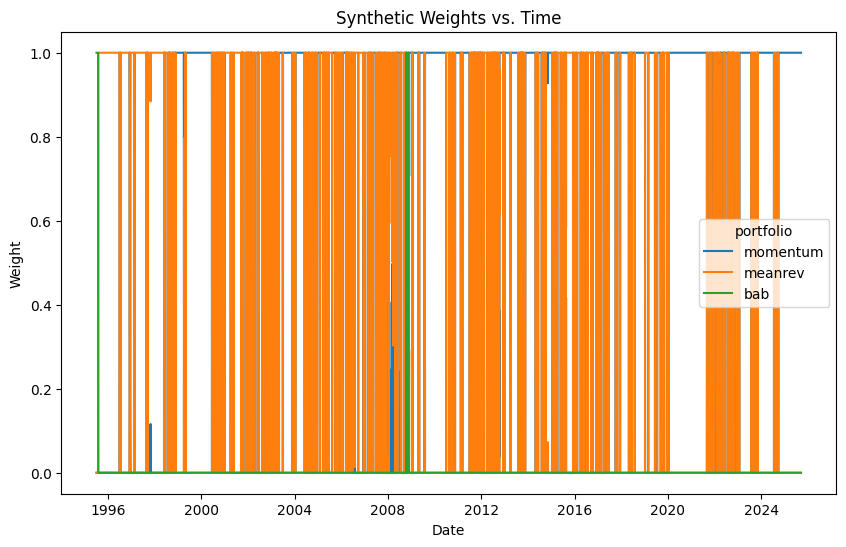

In [22]:
plt.figure(figsize=(10, 6))
sns.lineplot(portfolio_data, x='date', y='weight', hue='portfolio')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.title('Synthetic Weights vs. Time')

In [23]:
big_data = (
    big_data
    .with_columns(pl.col('momentum_weight').fill_null(0)
    )
    .with_columns(pl.col('meanrev_weight').fill_null(0)
    )
    .with_columns(pl.col('bab_weight').fill_null(0)
    )
)

In [24]:
meta_wide = (
    portfolio_data
    .pivot(values="weight", index="date", on="portfolio")
    .rename({"momentum": "momentum_mw", "meanrev": "meanrev_mw", "bab": "bab_mw"})
)

combined = big_data.join(meta_wide, on="date", how="inner")

final_weights = combined.with_columns([
    (pl.col("momentum_weight") * pl.col("momentum_mw") +
     pl.col("meanrev_weight")  * pl.col("meanrev_mw")  +
     pl.col("bab_weight")      * pl.col("bab_mw")
    ).alias("weight")
])

final_weights = final_weights.select(['date', 'barrid', 'weight'])

final_weights


date,barrid,weight
date,str,f64
1995-07-05,"""USAA191""",-8.3482e-7
1995-07-05,"""USAA1W1""",-1.1694e-7
1995-07-05,"""USAA1Y1""",-1.0630e-7
1995-07-05,"""USAA2L1""",-3.1682e-7
1995-07-05,"""USAA311""",0.000197
…,…,…
2025-09-15,"""USBQZR1""",-1.1498e-43
2025-09-15,"""USBRGT1""",-2.6883e-44
2025-09-15,"""USBRH21""",-1.4180e-43


In [25]:
print(final_weights.group_by('date').agg(pl.col('weight').sum()))
print(final_weights['weight'].sum())
print(final_weights.select('date').unique().to_numpy().shape)
print(final_weights.group_by('date').agg(pl.col('barrid').n_unique()))

shape: (7_600, 2)
┌────────────┬────────┐
│ date       ┆ weight │
│ ---        ┆ ---    │
│ date       ┆ f64    │
╞════════════╪════════╡
│ 2005-11-22 ┆ 1.0    │
│ 2001-12-12 ┆ 1.0    │
│ 1996-07-26 ┆ 1.0    │
│ 2008-10-08 ┆ 1.0    │
│ 2022-10-04 ┆ 1.0    │
│ …          ┆ …      │
│ 2004-10-22 ┆ 1.0    │
│ 2014-02-21 ┆ 1.0    │
│ 2016-08-26 ┆ 1.0    │
│ 2010-11-30 ┆ 1.0    │
│ 2004-02-03 ┆ 1.0    │
└────────────┴────────┘
7600.000000440615
(7600, 1)
shape: (7_600, 2)
┌────────────┬────────┐
│ date       ┆ barrid │
│ ---        ┆ ---    │
│ date       ┆ u32    │
╞════════════╪════════╡
│ 2007-04-30 ┆ 2807   │
│ 2004-10-28 ┆ 2847   │
│ 2002-09-03 ┆ 2591   │
│ 2012-09-18 ┆ 2721   │
│ 2025-04-11 ┆ 2508   │
│ …          ┆ …      │
│ 2014-07-02 ┆ 2967   │
│ 1999-10-12 ┆ 2816   │
│ 2003-05-14 ┆ 2564   │
│ 2022-01-12 ┆ 2843   │
│ 2000-07-03 ┆ 2925   │
└────────────┴────────┘


In [26]:
momentum_weights = weights_data.select(['date', 'barrid', 'momentum_weight']).rename({'momentum_weight': 'weight'})
meanrev_weights = weights_data.select(['date', 'barrid', 'meanrev_weight']).rename({'meanrev_weight': 'weight'})
bab_weights = weights_data.select(['date', 'barrid', 'bab_weight']).rename({'bab_weight': 'weight'})
equal_weights = (
    weights_data
    .with_columns(pl.col('momentum_weight').add(pl.col('meanrev_weight')).add(pl.col('bab_weight')).truediv(3).alias('equal_weight'))
    .select(['date', 'barrid', 'equal_weight'])
    .rename({'equal_weight': 'weight'})
)

In [27]:
bl_weights = pl.read_parquet('../signal_weights/bl_weights/bl_weights_pivot.parquet')

In [28]:
def get_returns_from_weights(weights: pl.DataFrame):
    """
    I'm too lazy too write doc strings, but weights should have JUST date, barrid, and weights,
    in particular IT MUST NOT HAVE fwd_return ALREADY!
    """
    start = weights["date"].min()
    end = weights["date"].max()

    columns = ["date", "barrid", "fwd_return"]

    returns = sfd.load_assets(start=start, end=end, in_universe=True, columns=columns)

    benchmark = sfd.load_benchmark(start=start, end=end)

    return (
        returns.join(weights, on=["date", "barrid"], how="left")
        .join(benchmark, on=["date", "barrid"], how="left", suffix="_bmk")
        .with_columns(pl.col("fwd_return").truediv(100))
        .with_columns(pl.col("weight").sub("weight_bmk").alias("weight_act"))
        .with_columns(pl.col('weight', 'weight_act', 'weight_bmk').fill_null(0))
        .rename({"weight": "total", "weight_bmk": "benchmark", "weight_act": "active"})
        .unpivot(
            index=["date", "barrid", "fwd_return"],
            variable_name="portfolio",
            value_name="weight",
        )
        .group_by("date", "portfolio")
        .agg(pl.col("fwd_return").mul("weight").sum().alias("return"))
        .sort("date", "portfolio")
        # .with_columns(pl.col('return').shift(1).over('portfolio')) # Technically this should be shifted, but it causes annoying problems
        .with_columns(pl.col('return').log1p().cum_sum().over('portfolio').alias('cumulative_log_return'))
    )


In [29]:
# This cell is slow because loading with sfd is kind of slow

synMVO_ret = get_returns_from_weights(final_weights)
momentum_ret = get_returns_from_weights(momentum_weights)
meanrev_ret = get_returns_from_weights(meanrev_weights)
bab_ret = get_returns_from_weights(bab_weights)
equal_ret = get_returns_from_weights(equal_weights)

In [30]:
bl_ret = get_returns_from_weights(bl_weights)

In [31]:
def plot_print_summary(returns: pl.DataFrame, xlabel='Date', ylabel='Cumulative Log Return', title='Signal Cumulative Log Returns', plot_save_path=None, table_save_path=None):
    """
    Make everyone's life easy and just run this on the output of get_returns_from_weights
    """
    plt.figure(figsize=(10, 6))
    sns.lineplot(returns, x='date', y='cumulative_log_return', hue='portfolio')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    table = sfp.generate_summary_table(returns)
    print(table)

    if plot_save_path:
        plt.savefig(plot_save_path)

    if table_save_path:
        table.write_csv(table_save_path)

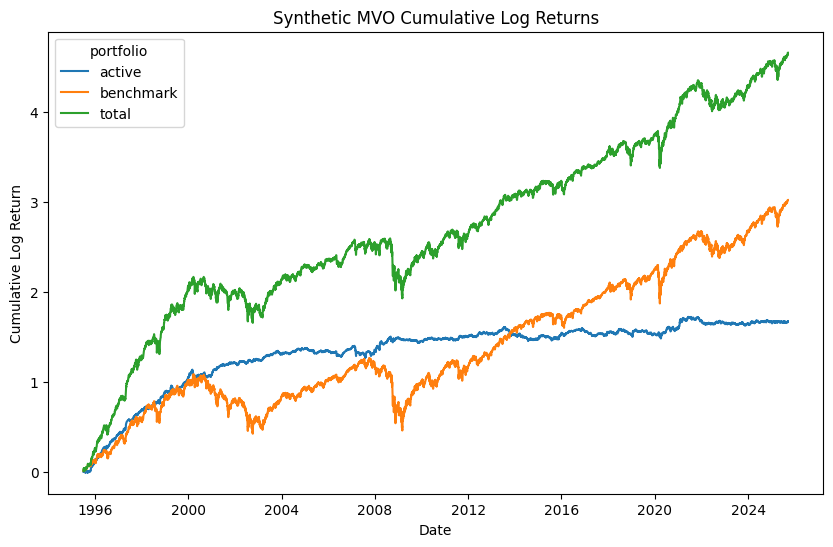

shape: (3, 6)
┌───────────┬───────┬─────────────────┬────────────────┬──────────────────┬────────┐
│ Portfolio ┆ Count ┆ Mean Return (%) ┆ Volatility (%) ┆ Total Return (%) ┆ Sharpe │
│ ---       ┆ ---   ┆ ---             ┆ ---            ┆ ---              ┆ ---    │
│ str       ┆ u32   ┆ f64             ┆ f64            ┆ f64              ┆ f64    │
╞═══════════╪═══════╪═════════════════╪════════════════╪══════════════════╪════════╡
│ Active    ┆ 7600  ┆ 5.74            ┆ 5.95           ┆ 434.7            ┆ 0.96   │
│ Benchmark ┆ 7600  ┆ 11.89           ┆ 19.27          ┆ 1956.75          ┆ 0.62   │
│ Total     ┆ 7600  ┆ 17.5            ┆ 20.18          ┆ 10472.24         ┆ 0.87   │
└───────────┴───────┴─────────────────┴────────────────┴──────────────────┴────────┘


In [32]:
plot_print_summary(synMVO_ret, title='Synthetic MVO Cumulative Log Returns')

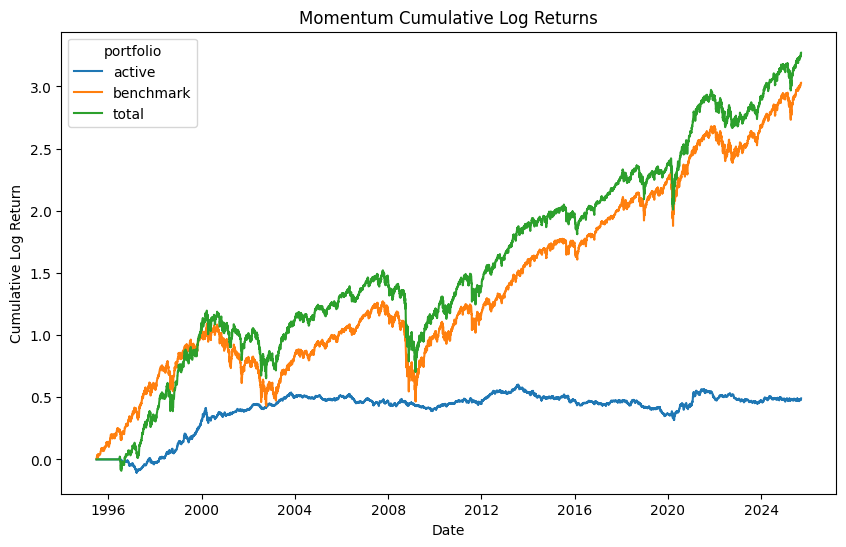

shape: (3, 6)
┌───────────┬───────┬─────────────────┬────────────────┬──────────────────┬────────┐
│ Portfolio ┆ Count ┆ Mean Return (%) ┆ Volatility (%) ┆ Total Return (%) ┆ Sharpe │
│ ---       ┆ ---   ┆ ---             ┆ ---            ┆ ---              ┆ ---    │
│ str       ┆ u32   ┆ f64             ┆ f64            ┆ f64              ┆ f64    │
╞═══════════╪═══════╪═════════════════╪════════════════╪══════════════════╪════════╡
│ Active    ┆ 7602  ┆ 1.76            ┆ 5.2            ┆ 63.4             ┆ 0.34   │
│ Benchmark ┆ 7602  ┆ 11.9            ┆ 19.27          ┆ 1968.19          ┆ 0.62   │
│ Total     ┆ 7602  ┆ 12.8            ┆ 19.75          ┆ 2534.59          ┆ 0.65   │
└───────────┴───────┴─────────────────┴────────────────┴──────────────────┴────────┘


In [33]:
plot_print_summary(momentum_ret, title='Momentum Cumulative Log Returns')

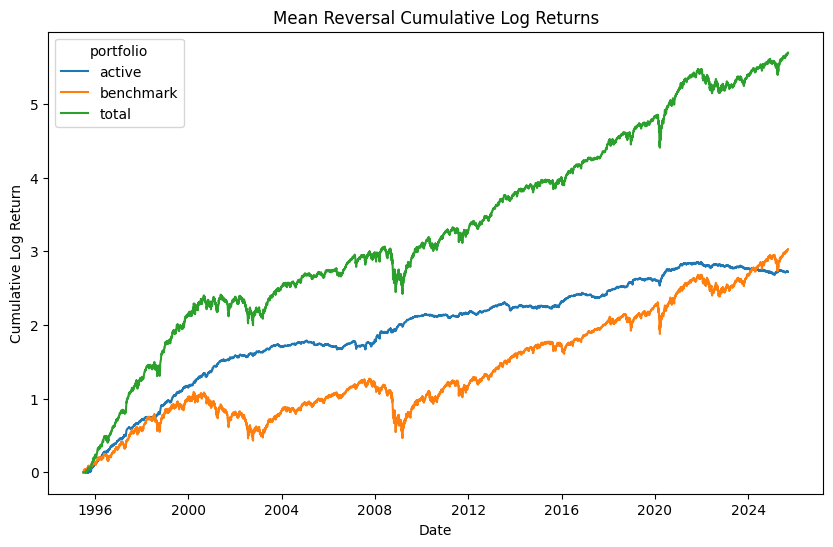

shape: (3, 6)
┌───────────┬───────┬─────────────────┬────────────────┬──────────────────┬────────┐
│ Portfolio ┆ Count ┆ Mean Return (%) ┆ Volatility (%) ┆ Total Return (%) ┆ Sharpe │
│ ---       ┆ ---   ┆ ---             ┆ ---            ┆ ---              ┆ ---    │
│ str       ┆ u32   ┆ f64             ┆ f64            ┆ f64              ┆ f64    │
╞═══════════╪═══════╪═════════════════╪════════════════╪══════════════════╪════════╡
│ Active    ┆ 7602  ┆ 9.19            ┆ 5.68           ┆ 1423.61          ┆ 1.62   │
│ Benchmark ┆ 7602  ┆ 11.9            ┆ 19.27          ┆ 1968.19          ┆ 0.62   │
│ Total     ┆ 7602  ┆ 20.91           ┆ 20.15          ┆ 29614.76         ┆ 1.04   │
└───────────┴───────┴─────────────────┴────────────────┴──────────────────┴────────┘


In [34]:
plot_print_summary(meanrev_ret, title='Mean Reversal Cumulative Log Returns')

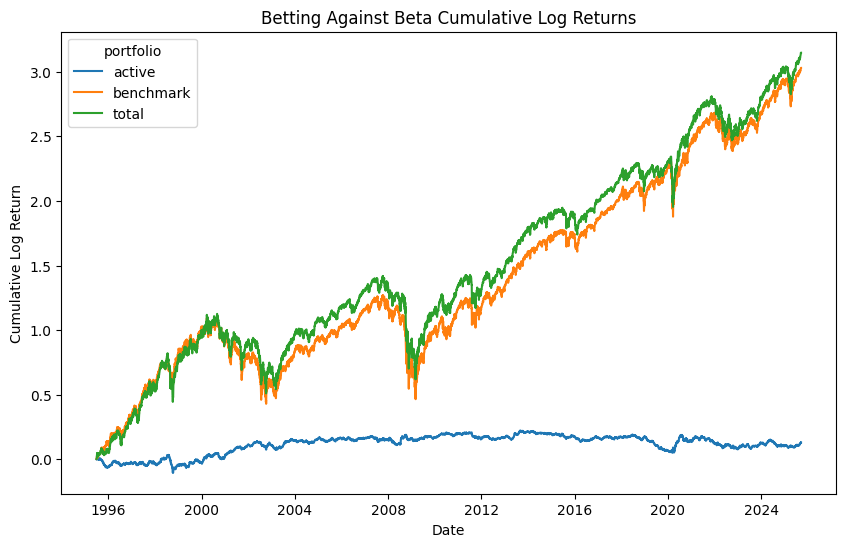

shape: (3, 6)
┌───────────┬───────┬─────────────────┬────────────────┬──────────────────┬────────┐
│ Portfolio ┆ Count ┆ Mean Return (%) ┆ Volatility (%) ┆ Total Return (%) ┆ Sharpe │
│ ---       ┆ ---   ┆ ---             ┆ ---            ┆ ---              ┆ ---    │
│ str       ┆ u32   ┆ f64             ┆ f64            ┆ f64              ┆ f64    │
╞═══════════╪═══════╪═════════════════╪════════════════╪══════════════════╪════════╡
│ Active    ┆ 7602  ┆ 0.51            ┆ 3.91           ┆ 13.98            ┆ 0.13   │
│ Benchmark ┆ 7602  ┆ 11.9            ┆ 19.27          ┆ 1968.19          ┆ 0.62   │
│ Total     ┆ 7602  ┆ 12.29           ┆ 19.24          ┆ 2225.99          ┆ 0.64   │
└───────────┴───────┴─────────────────┴────────────────┴──────────────────┴────────┘


In [35]:
plot_print_summary(bab_ret, title='Betting Against Beta Cumulative Log Returns')

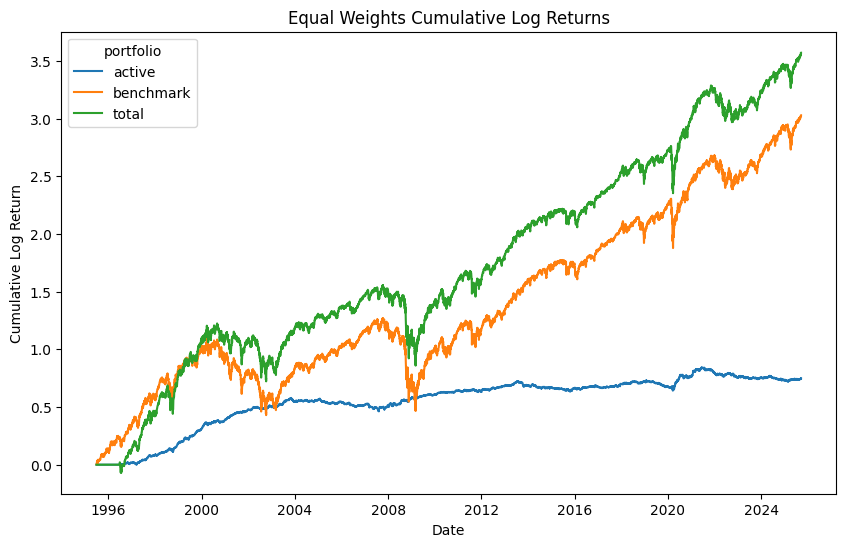

shape: (3, 6)
┌───────────┬───────┬─────────────────┬────────────────┬──────────────────┬────────┐
│ Portfolio ┆ Count ┆ Mean Return (%) ┆ Volatility (%) ┆ Total Return (%) ┆ Sharpe │
│ ---       ┆ ---   ┆ ---             ┆ ---            ┆ ---              ┆ ---    │
│ str       ┆ u32   ┆ f64             ┆ f64            ┆ f64              ┆ f64    │
╞═══════════╪═══════╪═════════════════╪════════════════╪══════════════════╪════════╡
│ Active    ┆ 7602  ┆ 2.53            ┆ 3.18           ┆ 111.5            ┆ 0.8    │
│ Benchmark ┆ 7602  ┆ 11.9            ┆ 19.27          ┆ 1968.19          ┆ 0.62   │
│ Total     ┆ 7602  ┆ 13.57           ┆ 18.59          ┆ 3456.76          ┆ 0.73   │
└───────────┴───────┴─────────────────┴────────────────┴──────────────────┴────────┘


In [36]:
plot_print_summary(equal_ret, title='Equal Weights Cumulative Log Returns')

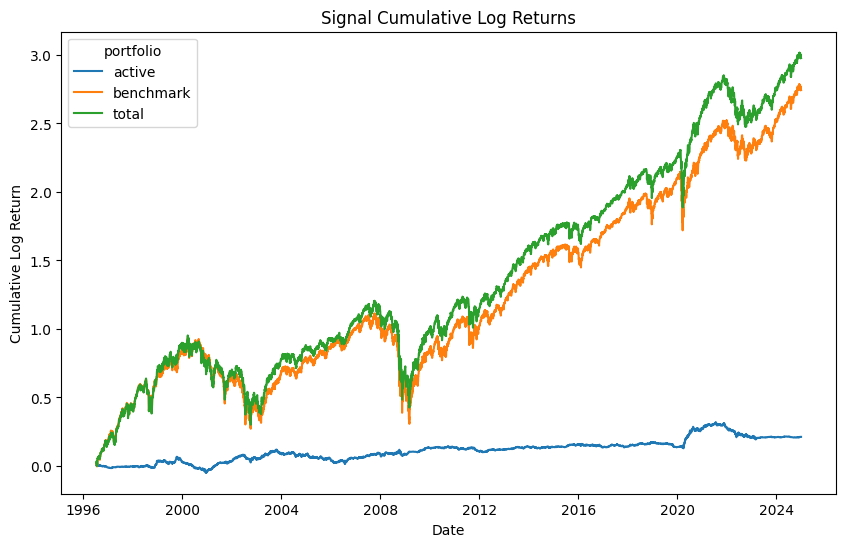

shape: (3, 6)
┌───────────┬───────┬─────────────────┬────────────────┬──────────────────┬────────┐
│ Portfolio ┆ Count ┆ Mean Return (%) ┆ Volatility (%) ┆ Total Return (%) ┆ Sharpe │
│ ---       ┆ ---   ┆ ---             ┆ ---            ┆ ---              ┆ ---    │
│ str       ┆ u32   ┆ f64             ┆ f64            ┆ f64              ┆ f64    │
╞═══════════╪═══════╪═════════════════╪════════════════╪══════════════════╪════════╡
│ Active    ┆ 7164  ┆ 0.79            ┆ 2.82           ┆ 23.61            ┆ 0.28   │
│ Benchmark ┆ 7164  ┆ 11.55           ┆ 19.47          ┆ 1453.87          ┆ 0.59   │
│ Total     ┆ 7164  ┆ 12.34           ┆ 19.28          ┆ 1862.82          ┆ 0.64   │
└───────────┴───────┴─────────────────┴────────────────┴──────────────────┴────────┘


In [37]:
plot_print_summary(bl_ret)